In [2]:
import os
import sys
sys.path.append("/home/ksavevska/talos_ws/dmpbbo")
import dmpbbo.json_for_cpp as jc
from dmpbbo.dmps.Trajectory import Trajectory
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from pytransform3d.rotations import quaternion_integrate, matrix_from_quaternion, plot_basis
import copy
import quaternion
from dtaidistance import dtw

In [3]:
plt.rcParams.update({"text.usetex": True,
              "font.family": "serif",
              "font.serif": ["Computer Modern Roman"], 
              "font.weight": "medium",
              "font.style": "normal",
              "font.size": 14,
              "figure.figsize": [4.9, 3.5],
              "axes.linewidth": 0.4})

In [3]:
results_22_lr03 = "results_short_traj_upper_body_goal_dtw_22_lr03/"
results_23_lr03 = "results_short_traj_upper_body_goal_dtw_23_lr03/"
results_29_lr03 = "results_short_traj_upper_body_goal_dtw_29_lr03/"

In [21]:
def compare_ee_trajs(result, output_dir):
    cost_varss = [np.loadtxt("results_short_traj_upper_body_goal_dtw_40_lr03_pos/update00000/eval_cost_vars.txt"),
                  np.loadtxt(result+"update00149/eval_cost_vars.txt"),
                  np.loadtxt("results_short_traj_upper_body_goal_dtw_40_lr03_pos/update00000/eval_cost_vars_robot.txt"),
                  np.loadtxt(result+"update00149/eval_cost_vars_robot.txt")]
        
    
    labels = [r"\textbf{Simulation} \hspace{2mm} initial", "optimal", r"\textbf{Robot} \hspace{6.5mm} initial", "optimal"]
    
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:gray"]
    colors = ["black", "black", "tab:red", "tab:red"]    
    
    
    n_misc = 15
    n=0
    m=-1
    fig3d = plt.figure(figsize=(10,6))
    ax = fig3d.add_subplot(111, projection="3d")
    ax.view_init(None, 220)
    for i, cost_vars in enumerate(cost_varss):
        ee_pos_x = cost_vars[n:m,-n_misc+2]
        ee_pos_y = cost_vars[n:m,-n_misc+3]
        ee_pos_z = cost_vars[n:m,-n_misc+4]
        if "initial" in labels[i]:
            ax.plot(ee_pos_x, ee_pos_y, ee_pos_z, linewidth=2.0, linestyle="--", alpha=0.5, color=colors[i], label=labels[i])
        else:
            ax.plot(ee_pos_x, ee_pos_y, ee_pos_z, linewidth=1.5,color=colors[i], label=labels[i])
            
    ax.scatter(0.65, -0.4, 0.00, s=100, color="gray")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")  
    ax.legend(alignment='left', markerfirst=False)
#     ax.set_title("EE trajectory comparison")
    plt.savefig(output_dir+"/ee_traj_comparison.pdf", dpi=1000, format="pdf", bbox_inches='tight')
#     plt.savefig(output_dir+"/ee_traj_comparison.jpg")

    plt.show()

In [22]:
def compare_zmps(result, output_dir, initial=True):
    if initial:
        cost_varss = [np.loadtxt("results_short_traj_upper_body_goal_dtw_40_lr03_pos/update00000/eval_cost_vars.txt"),
                      np.loadtxt(result+"update00149/eval_cost_vars.txt"),
                      np.loadtxt("results_short_traj_upper_body_goal_dtw_40_lr03_pos/update00000/eval_cost_vars_robot.txt"),
                      np.loadtxt(result+"update00149/eval_cost_vars_robot.txt")]
#         labels = ["initial simulation", "initial robot", "optimal simulation", "optimal robot"]
        labels = [r"\textbf{Simulation} \hspace{2mm} initial", "optimal", r"\textbf{Robot} \hspace{6.5mm} initial", "optimal"]
        
    else:
        cost_varss = [np.loadtxt(result+"update00149/eval_cost_vars.txt"),
                      np.loadtxt(result+"update00149/eval_cost_vars_robot.txt")]
        labels = [r"\textbf{Simulation} optimal", r"\textbf{Robot} optimal"]


    n_misc = 15
        
#     colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:gray"]
    colors = ["black", "black", "tab:red", "tab:red"]
    linestyles = ['--', '-', '--', '-']
    linewidths = [2.0, 1.5, 2.0, 1.5, 2.0]
    alphas = [0.5, 1.0, 0.5, 1.0, 0.5]
    

    fig = plt.figure(figsize=(6,4))#figsize=(30*cm,20*cm))

    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[:, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])

    for i, cost_vars in enumerate(cost_varss):
        # Calculate borders of the support polygon
        x_size = 0.21
        y_size = 0.13
        sp_y_1 = cost_vars[0, -2] - y_size/2
        sp_y_2 = cost_vars[0, -5] + y_size/2
        sp_x_1 = max(cost_vars[0, -6] - x_size/2, cost_vars[0, -3] - x_size/2)
        sp_x_2 = min(cost_vars[0, -6] + x_size/2, cost_vars[0, -3] + x_size/2)
        
        # Calculate middle point from the borders as ref_cop
        # ref_cop_ = [(sp_x_1 + sp_x_2) / 2, (sp_y_1 + sp_y_2) / 2]
        ref_cop_ = [(sp_x_1 + sp_x_2) / 2, (sp_y_1 + sp_y_2) / 2]


        # Get the actual COP moved to match 
        cop_y = copy.copy(cost_vars[:,-n_misc+1])
        cop_x = copy.copy(cost_vars[:,-n_misc])
        cop_x -= ref_cop_[0]

        # cop_x -= ref_cop_[0]
        # cop_y -= ref_cop_[1]

        df = pd.DataFrame(data=np.array([cop_x, cop_y]).T, columns=["x", "y"])


        n=0
        if initial:
            ax1.plot(df['x'].iloc[n:].rolling(1,1).mean(), df['y'].iloc[n:].rolling(1,1).mean(), label=labels[i], color=colors[i], linewidth=linewidths[i], linestyle=linestyles[i], alpha=alphas[i])
        else:
            ax1.plot(df['x'].iloc[n:].rolling(1,1).mean(), df['y'].iloc[n:].rolling(1,1).mean(), label=labels[i], color=colors[i+1], linewidth=1.5)
        # ax1.scatter(df['x'].iloc[n::10].rolling(30,1).mean(), df['y'].iloc[n::10].rolling(30,1).mean(), label="Update "+str(i*50), s=10)

        ts = np.array(range(0, len(cost_vars)))/120
        if initial:
            ax2.plot(ts[n:], cop_x[n:], color=colors[i], linewidth=linewidths[i]-0.5, linestyle=linestyles[i], alpha=alphas[i])
            ax3.plot(ts[n:], cop_y[n:], color=colors[i], linewidth=linewidths[i]-0.5, linestyle=linestyles[i], alpha=alphas[i])

        else:
            ax2.plot(ts[n:], cop_x[n:], color=colors[i+1], linewidth=1.0)
            ax3.plot(ts[n:], cop_y[n:], color=colors[i+1], linewidth=1.0)
    x_size = 0.21
    y_size = 0.13
    sp_y_1 = cost_vars[0, -2] - y_size/2
    sp_y_2 = cost_vars[0, -5] + y_size/2
    sp_x_1 = max(cost_vars[0, -6] - x_size/2, cost_vars[0, -3] - x_size/2)
    sp_x_2 = min(cost_vars[0, -6] + x_size/2, cost_vars[0, -3] + x_size/2)
    
    sp_x_1 = -x_size/2
    sp_x_2 = x_size/2
    ax2.plot(ts[n:], [sp_x_1]*len(cop_x[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
    ax2.plot(ts[n:], [sp_x_1+x_size]*len(cop_x[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
    ax2.set_ylabel("x")
    ax2.set_xlabel("[s]")
    ax2.set_xlim([ts[n], ts[-1]])
        

    ax3.plot(ts[n:], [sp_y_1]*len(cop_y[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
    ax3.plot(ts[n:], [sp_y_2]*len(cop_y[n:]), color="gray", linestyle='--', linewidth=2, alpha=0.5)
    ax3.set_ylabel("y")
    ax3.set_xlabel("[s]")
    ax3.set_xlim([ts[n], ts[-1]])

    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax1.add_patch(plt.Rectangle((sp_x_1, sp_y_1), x_size, y_size,
                                  fill=True, color='gray', alpha=0.5))

    ax1.add_patch(plt.Rectangle(( sp_x_1, sp_y_2-y_size), x_size, y_size,
                                  fill=True, color='gray', alpha=0.5))
    ax1.text(-0.06, sp_y_2-y_size/2-0.01, "left foot", color="gray")
    ax1.text(-0.06, sp_y_1+y_size/2, "right foot", color="gray")

    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    ax1.hlines(sp_y_1, xmin=sp_x_1, xmax=sp_x_1+x_size, linestyle='--', color='gray', linewidth=2, alpha=0.5) # horizontal lines
    ax1.hlines(sp_y_2, xmin=sp_x_1, xmax=sp_x_1+x_size, linestyle='--', color='gray', linewidth=2, alpha=0.5) # horizontal lines
    ax1.vlines(sp_x_1,        ymin=sp_y_1, ymax=sp_y_2, linestyle='--', color='gray', linewidth=2, alpha=0.5)        
    ax1.vlines(sp_x_1+x_size, ymin=sp_y_1, ymax=sp_y_2, linestyle='--', color='gray', linewidth=2, alpha=0.5)        
    
    ax1.set_ylim([-0.25,0.25])
    # ax1.set_xlim([-0.1,0.15])


    ax1.legend(loc="lower left", fontsize=10, markerfirst=False)#, bbox_to_anchor=(1, 0.5))
    # ax1.locator_params(axis='x', nbins=5)
    ax1.locator_params(axis='y', nbins=5)
    ax2.locator_params(axis='x', nbins=5)
    # ax2.locator_params(axis='y', nbins=5)
    ax3.locator_params(axis='x', nbins=5)
    # ax3.locator_params(axis='y', nbins=5)
#     fig.suptitle("ZMP trajectory comparison")
    fig.tight_layout()
    fig.savefig(output_dir + "/zmp_traj_comparison.pdf", dpi=1000, format="pdf", bbox_inches='tight')
#     fig.savefig(output_dir + "/zmp_traj_comparison.jpg")

    plt.show()

In [17]:
def q_dist(q1, q2):
    prod = q1*q2.conj()
    prod = prod/np.linalg.norm(quaternion.as_float_array(prod))
    # log = np.arccos(prod.real)*(prod.imag/np.linalg.norm(prod.imag))
    log = np.log(prod).imag
    return 2*np.linalg.norm(log)

def calculate_dist_to_cop(cost_vars, rf_x=None, rf_y=None, lf_x=None, lf_y=None):                        
    n_misc = 15                                                                                         
    cop_x = cost_vars[:,-n_misc]                                  
    cop_y = cost_vars[:,-n_misc+1]                                   
    if rf_x == None:
        rf_y = cost_vars[0, -2]                                                            
        lf_y = cost_vars[0, -5]                       
        rf_x = cost_vars[0, -3]
        lf_x = cost_vars[0, -6]             

    ref_cop = np.array([(rf_x + lf_x)/2, (rf_y + lf_y)/2])
    print(ref_cop)
    dist_to_cop = np.sum((1/len(cop_x))*np.sqrt((cop_x - ref_cop[0])**2 + (cop_y - ref_cop[1])**2))
    return dist_to_cop

def reaching_errors(result):

    df_errors = pd.DataFrame(columns=["simulation", "robot"], 
                             index=["Positional error", "Orientational error", "Average distance from CSP"])
    
    cost_varss = [np.loadtxt(result+"update00149/eval_cost_vars.txt"),
                  np.loadtxt(result+"update00149/eval_cost_vars_robot.txt")]
    labels = ["optimal simulation", "optimal robot"]
    n_misc=15
    for i, cost_vars in enumerate(cost_varss):
        ee_pos_goal_ = [0.65, -0.4, 0.0] 

        cop_x = cost_vars[:,-n_misc]
        cop_y = cost_vars[:,-n_misc+1]

        ee_pos_x = cost_vars[:,-n_misc+2]
        ee_pos_y = cost_vars[:,-n_misc+3]
        ee_pos_z = cost_vars[:,-n_misc+4]

        ee_rot_x = cost_vars[:,-n_misc+5]
        ee_rot_y = cost_vars[:,-n_misc+6]
        ee_rot_z = cost_vars[:,-n_misc+7]
        ee_rot_w = cost_vars[:,-n_misc+8]
        dist_to_goal = (np.sqrt((ee_pos_x[-1] - ee_pos_goal_[0])**2 + (ee_pos_y[-1]-ee_pos_goal_[1])**2 + (ee_pos_z[-1]-ee_pos_goal_[2])**2))

        q_desired = quaternion.from_float_array([0.5, 0.5, -0.5, -0.5])
        q_goal = quaternion.from_float_array([ee_rot_w[-1], ee_rot_x[-1], ee_rot_y[-1], ee_rot_z[-1]])
        orientation_cost = q_dist(q_desired, q_goal)    
        
        if "simulation" in labels:
            dist_cop = calculate_dist_to_cop(cost_vars, -0.00894106, -0.08461586, -0.00908674,  0.08459641)
        else:
            dist_cop = calculate_dist_to_cop(cost_vars)
        
        df_errors[df_errors.columns[i]].loc["Positional error"] = dist_to_goal
        df_errors[df_errors.columns[i]].loc["Orientational error"] = orientation_cost
        df_errors[df_errors.columns[i]].loc["Average distance from CSP"] = dist_cop
    return df_errors


In [18]:
results_robot = ["results_short_traj_upper_body_goal_dtw_28_lr03/",
                 "results_short_traj_upper_body_goal_dtw_29_lr03/",
                 "results_short_traj_upper_body_goal_dtw_40_lr03_pos/",
                 "results_short_traj_upper_body_goal_dtw_31_lr03/",
                 "results_short_traj_upper_body_goal_dtw_32_lr03/",
                 "results_short_traj_upper_body_goal_dtw_42_lr03_pos/",
                 "results_short_traj_upper_body_goal_dtw_43_lr03_pos/"]

output_dirs = ["plots_robot/results_short_traj_upper_body_goal_dtw_28_lr03/",
               "plots_robot/results_short_traj_upper_body_goal_dtw_29_lr03/",
               "plots_robot/results_short_traj_upper_body_goal_dtw_40_lr03_pos/",
               "plots_robot/results_short_traj_upper_body_goal_dtw_31_lr03/",
               "plots_robot/results_short_traj_upper_body_goal_dtw_32_lr03/",
               "plots_robot/results_short_traj_upper_body_goal_dtw_42_lr03_pos/",
               "plots_robot/results_short_traj_upper_body_goal_dtw_43_lr03_pos/"]

In [23]:
results_robot = ["results_short_traj_upper_body_goal_dtw_40_lr03_pos/",
                 "results_short_traj_upper_body_goal_dtw_48_lr03_pos/",
                 "results_short_traj_upper_body_goal_dtw_58_lr03_pos/"]

output_dirs = ["plots_robot/plots_stab_goal_orient/",
               "plots_robot/plots_stab_goal_orient_traj/",
               "plots_robot/plots_stab_goal_orient_traj_acc/"]

results_short_traj_upper_body_goal_dtw_40_lr03_pos/


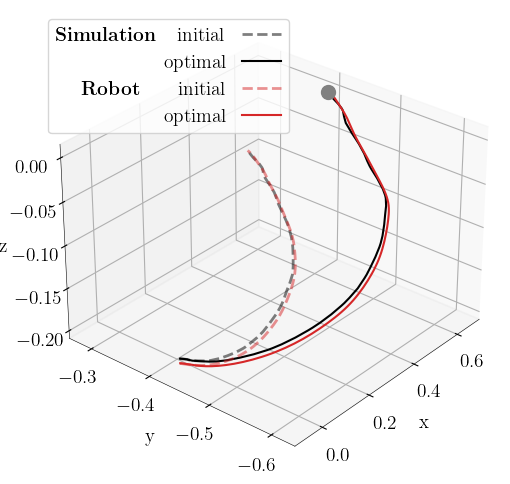

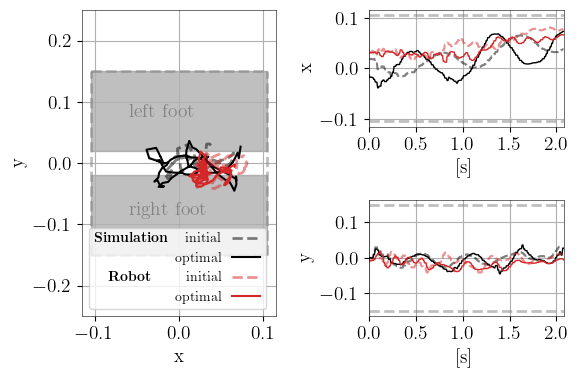

[-0.02934465 -0.00054359]
[-3.17623520e-02  4.60683998e-08]
                          simulation     robot
Positional error            0.001188  0.005642
Orientational error         0.006131  0.011407
Average distance from CSP   0.033669  0.044191


results_short_traj_upper_body_goal_dtw_48_lr03_pos/


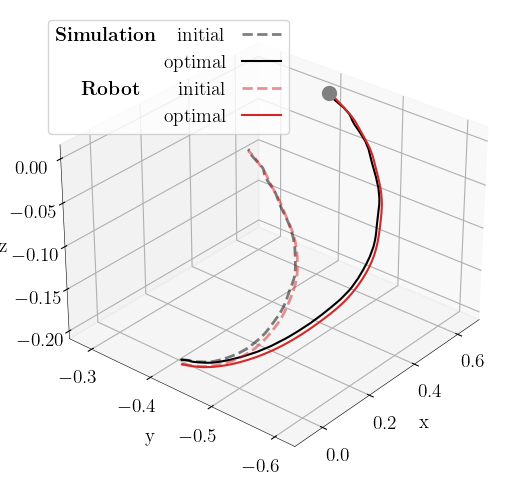

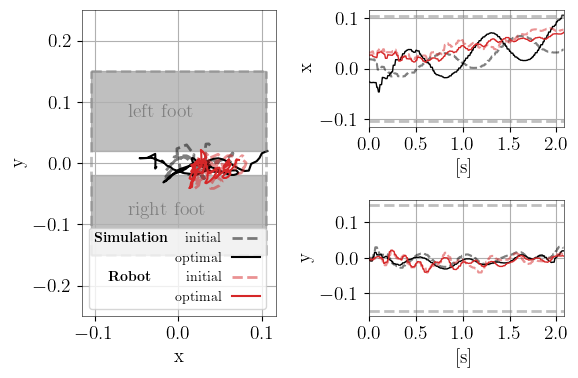

[-0.0293122 -0.003086 ]
[-3.17631004e-02  1.67716478e-07]
                          simulation     robot
Positional error            0.007117   0.00291
Orientational error          0.00953  0.009422
Average distance from CSP   0.037863  0.044636


results_short_traj_upper_body_goal_dtw_58_lr03_pos/


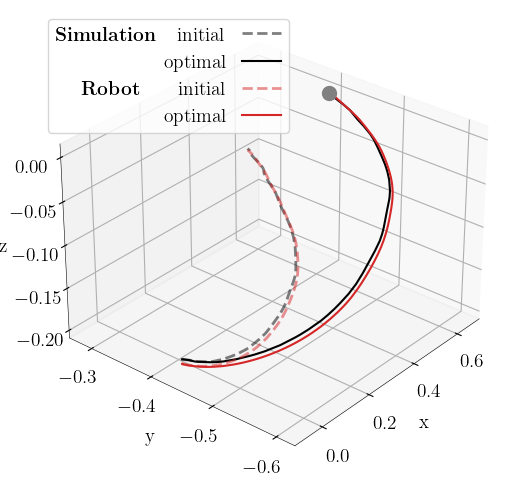

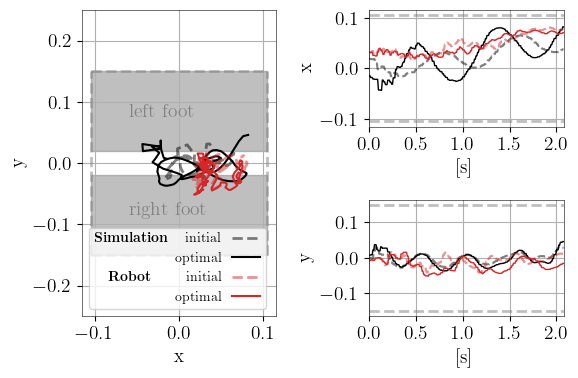

[-0.02827403  0.00554166]
[-3.17638362e-02 -1.83899714e-07]
                          simulation     robot
Positional error            0.002542  0.002342
Orientational error         0.004848  0.012006
Average distance from CSP   0.042439  0.053247




In [24]:
for i, result in enumerate(results_robot):
    print(result)
    compare_ee_trajs(result, output_dirs[i])
    compare_zmps(result, output_dirs[i], initial=True)
    df = reaching_errors(result)
    print(df.head())
    print("\n")

In [6]:
results_robot[0]

'results_short_traj_upper_body_goal_dtw_28_lr03/'

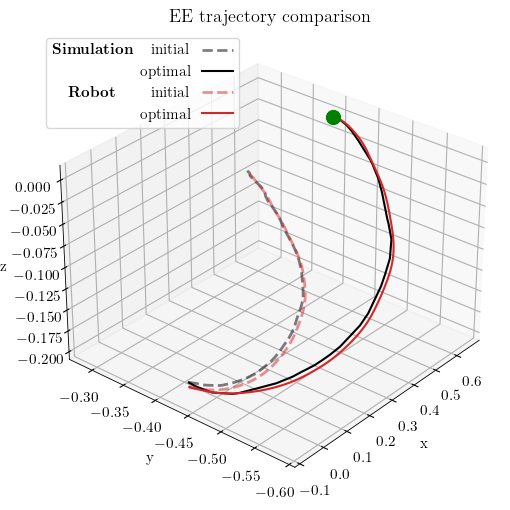

In [98]:
compare_ee_trajs(results_robot[0], "")

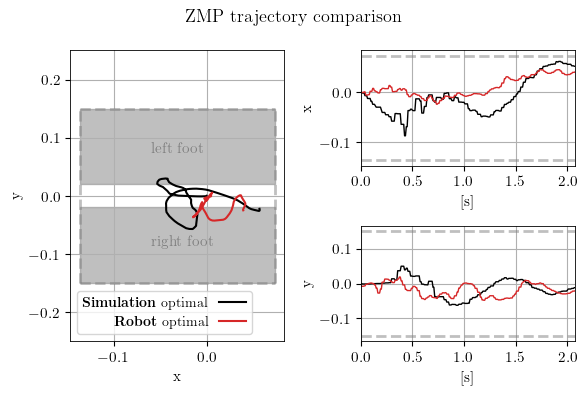

In [114]:
compare_zmps(results_robot[0], "", initial=True)

In [45]:
reaching_errors(results_robot[0])

[-0.02899715  0.001017  ]
[-3.17623520e-02 -1.41576264e-07]


,simulation,robot
Positional error,0.003865,0.004805
Orientational error,0.013117,0.007268
Average distance from CSP,0.042555,0.050083


In [ ]:
# For each result plot the initial from the simulation and the robot and final reaching trajectories

In [ ]:
# Also the cop for each result initial and final

In [ ]:
# table with the final errors to the reaching point and average distance to the csp 
# for the distance from the csp I need the poses of the feet, so thy should be the same on the robot and I can print them in the init function
('Left leg pose = ', array([-0.00908674,  0.08459641,  0.10988499]))
('Right leg pose = ', array([-0.00894106, -0.08461586,  0.10988518]))



In [29]:
results = results_22_lr03
cost_vars_sim = np.loadtxt(results + "update00149/eval_cost_vars.txt")
cost_vars_robot = np.loadtxt(results + "update00149/eval_cost_vars_robot.txt")

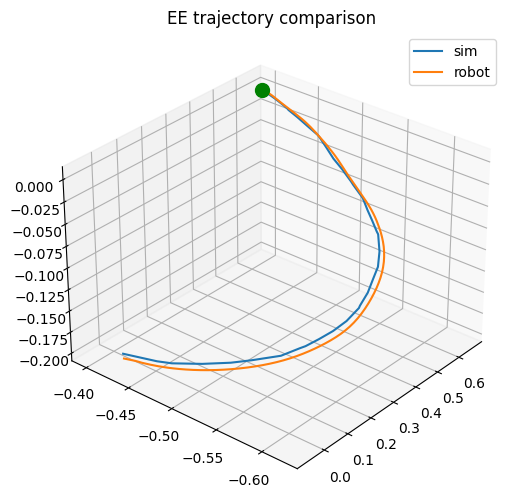

In [30]:
n_misc=15
ee_pos_x_sim = cost_vars_sim[:,-n_misc+2]
ee_pos_y_sim = cost_vars_sim[:,-n_misc+3]
ee_pos_z_sim = cost_vars_sim[:,-n_misc+4]

ee_pos_x_robot= cost_vars_robot[:,-n_misc+2]
ee_pos_y_robot= cost_vars_robot[:,-n_misc+3]
ee_pos_z_robot= cost_vars_robot[:,-n_misc+4]

fig3d = plt.figure(figsize=(10,6))
ax = fig3d.add_subplot(111, projection="3d")
ax.view_init(None, 220)
n=0
ax.plot(ee_pos_x_sim[n:], ee_pos_y_sim[n:], ee_pos_z_sim[n:], linewidth=1.5, label="sim")
ax.plot(ee_pos_x_robot[n:], ee_pos_y_robot[n:], ee_pos_z_robot[n:], linewidth=1.5, label="robot")
ax.scatter(0.65, -0.4, 0.00, s=100, color="green")
ax.legend()
ax.set_title("EE trajectory comparison")
plt.show()

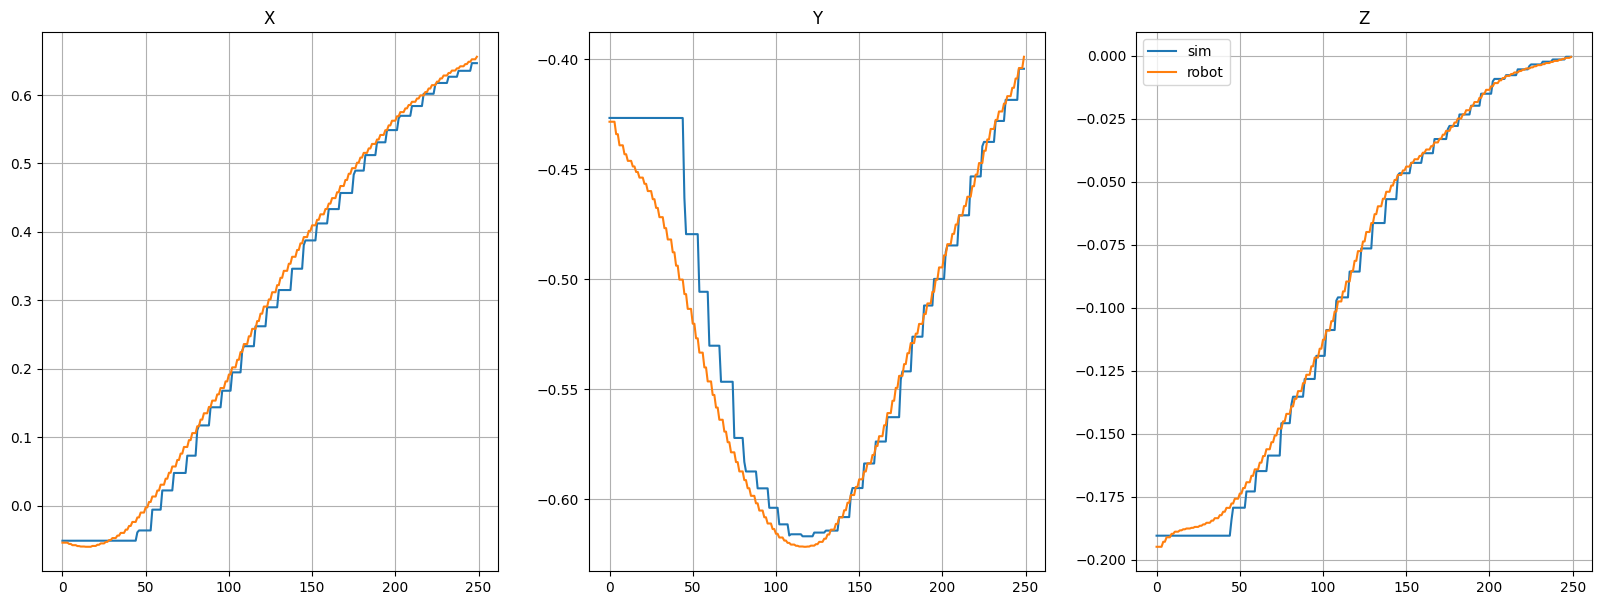

In [31]:
fig, (axx, axy, axz) = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
axx.plot(ee_pos_x_sim, label="sim")
axx.plot(ee_pos_x_robot, label="robot")
axx.grid()
axx.set_title("X")

axy.plot(ee_pos_y_sim, label="sim")
axy.plot(ee_pos_y_robot, label="robot")
axy.grid()
axy.set_title("Y")

axz.plot(ee_pos_z_sim, label="sim")
axz.plot(ee_pos_z_robot, label="robot")
axz.grid()
axz.set_title("Z")
axz.legend()
plt.show()

In [32]:
cop_x_sim = cost_vars_sim[:,-n_misc]                                  
cop_y_sim = cost_vars_sim[:,-n_misc+1]                                   

cop_x_robot = cost_vars_robot[:,-n_misc]                                  
cop_y_robot = cost_vars_robot[:,-n_misc+1]                                   

lf_y = cost_vars_robot[0, -5]                       
lf_x = cost_vars_robot[0, -6]

cop_x_robot = cop_x_robot + lf_x
cop_y_robot = cop_y_robot + lf_y

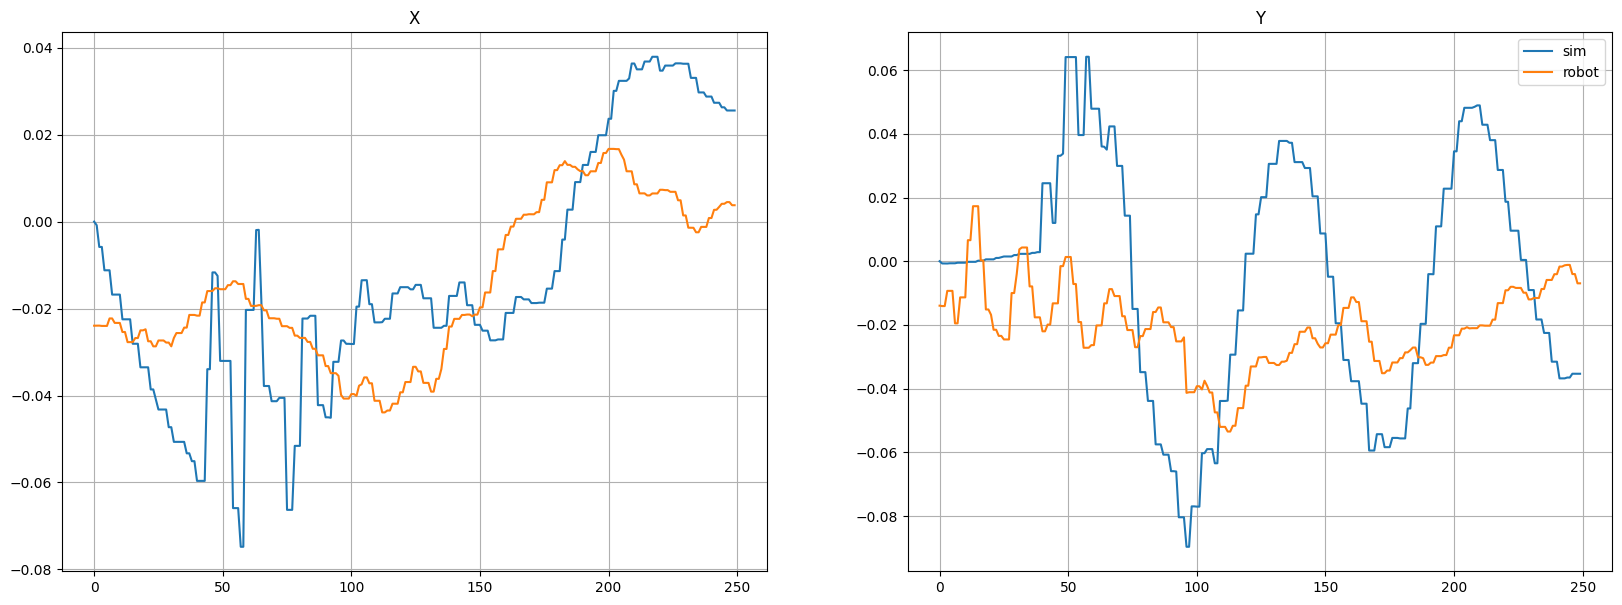

In [33]:
fig, (axx, axy) = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
axx.plot(cop_x_sim, label="sim")
axx.plot(cop_x_robot, label="robot")
axx.grid()
axx.set_title("X")

axy.plot(cop_y_sim, label="sim")
axy.plot(cop_y_robot, label="robot")
axy.grid()
axy.set_title("Y")
axy.legend()
plt.show()

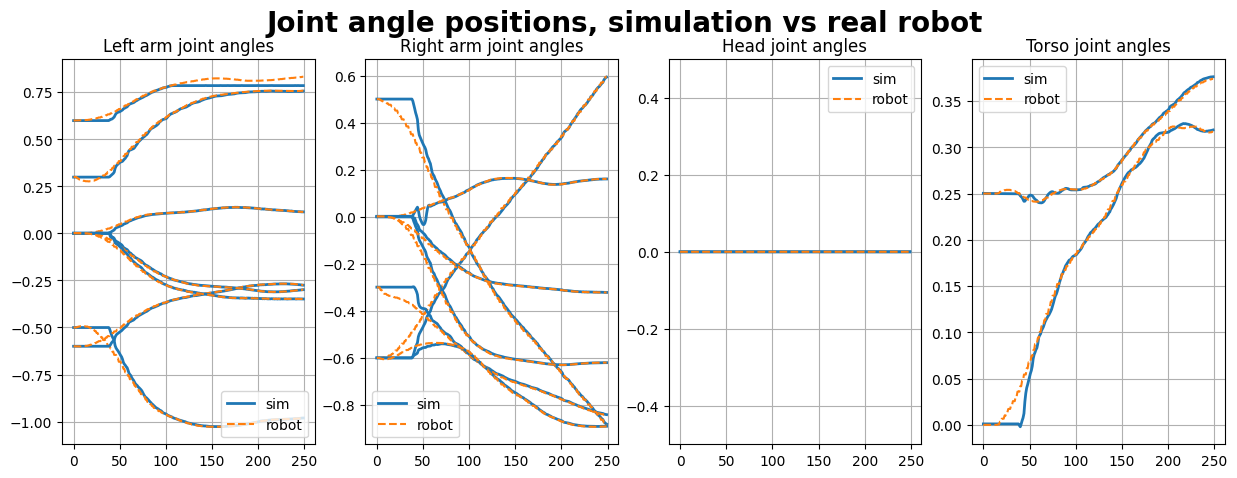

In [38]:
n_dims = 18
pos_sim = cost_vars_sim[:,:n_dims]
pos_robot = cost_vars_robot[:,:n_dims]

colors = ["tab:blue", "tab:orange", "tab:green", "black", "tab:purple", "tab:gray", "tab:blue"]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,5))
for i in range(7):
    ax1.plot(pos_sim[:,i], linestyle="-", linewidth=2, color=colors[0])
    ax1.plot(pos_robot[:,i], linestyle="--", linewidth=1.5, color=colors[1])
    ax1.set_title("Left arm joint angles")
for i in range(7,14):
    ax2.plot(pos_sim[:,i], linestyle="-", linewidth=2, color=colors[0])
    ax2.plot(pos_robot[:,i], linestyle="--", linewidth=1.5, color=colors[1])
    ax2.set_title("Right arm joint angles")
for i in range(14,16):
    ax3.plot(pos_sim[:,i], linestyle="-", linewidth=2, color=colors[0])
    ax3.plot(pos_robot[:,i], linestyle="--", linewidth=1.5, color=colors[1])
    ax3.set_title("Head joint angles")
for i in range(16,18):
    ax4.plot(pos_sim[:,i], linestyle="-", linewidth=2, color=colors[0])
    ax4.plot(pos_robot[:,i], linestyle="--", linewidth=1.5, color=colors[1])
    ax4.set_title("Torso joint angles")    

fig.suptitle("Joint angle positions, simulation vs real robot", weight="bold", fontsize=20)
ax1.legend(["sim", "robot"], loc="lower right")
ax2.legend(["sim", "robot"])
ax3.legend(["sim", "robot"])
ax4.legend(["sim", "robot"])

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax3.set_ylim([-0.5, 0.5])

plt.show()

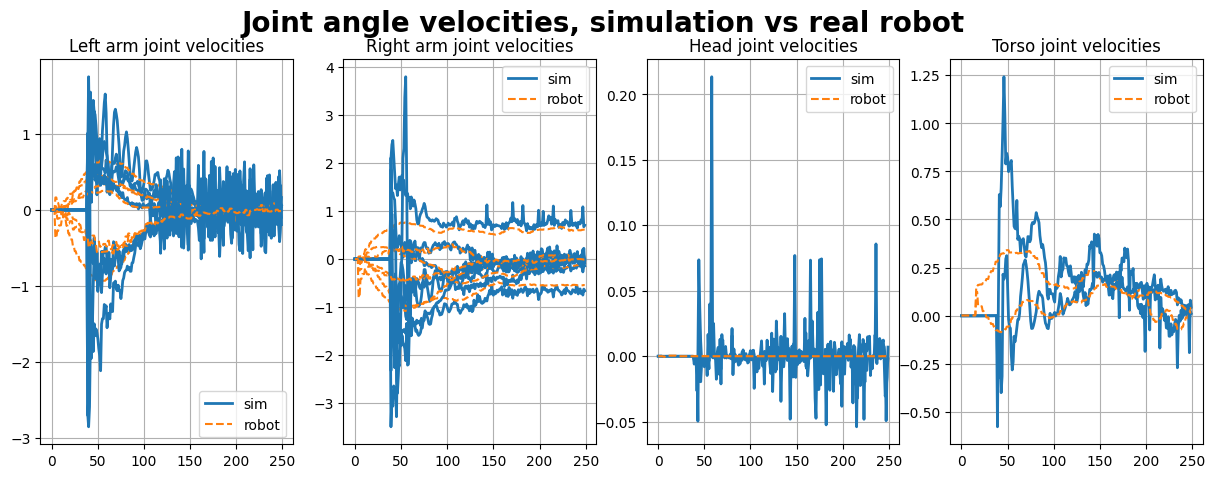

In [39]:
n_dims = 18
vel_sim = cost_vars_sim[:,n_dims:2*n_dims]
vel_robot = cost_vars_robot[:,n_dims:2*n_dims]

colors = ["tab:blue", "tab:orange", "tab:green", "black", "tab:purple", "tab:gray", "tab:blue"]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,5))
for i in range(7):
    ax1.plot(vel_sim[:,i], linestyle="-", linewidth=2, color=colors[0])
    ax1.plot(vel_robot[:,i], linestyle="--", linewidth=1.5, color=colors[1])
    ax1.set_title("Left arm joint velocities")
for i in range(7,14):
    ax2.plot(vel_sim[:,i], linestyle="-", linewidth=2, color=colors[0])
    ax2.plot(vel_robot[:,i], linestyle="--", linewidth=1.5, color=colors[1])
    ax2.set_title("Right arm joint velocities")
for i in range(14,16):
    ax3.plot(vel_sim[:,i], linestyle="-", linewidth=2, color=colors[0])
    ax3.plot(vel_robot[:,i], linestyle="--", linewidth=1.5, color=colors[1])
    ax3.set_title("Head joint velocities")
for i in range(16,18):
    ax4.plot(vel_sim[:,i], linestyle="-", linewidth=2, color=colors[0])
    ax4.plot(vel_robot[:,i], linestyle="--", linewidth=1.5, color=colors[1])
    ax4.set_title("Torso joint velocities")    

fig.suptitle("Joint angle velocities, simulation vs real robot", weight="bold", fontsize=20)
ax1.legend(["sim", "robot"], loc="lower right")
ax2.legend(["sim", "robot"])
ax3.legend(["sim", "robot"])
ax4.legend(["sim", "robot"])

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

# ax3.set_ylim([-0.5, 0.5])

plt.show()

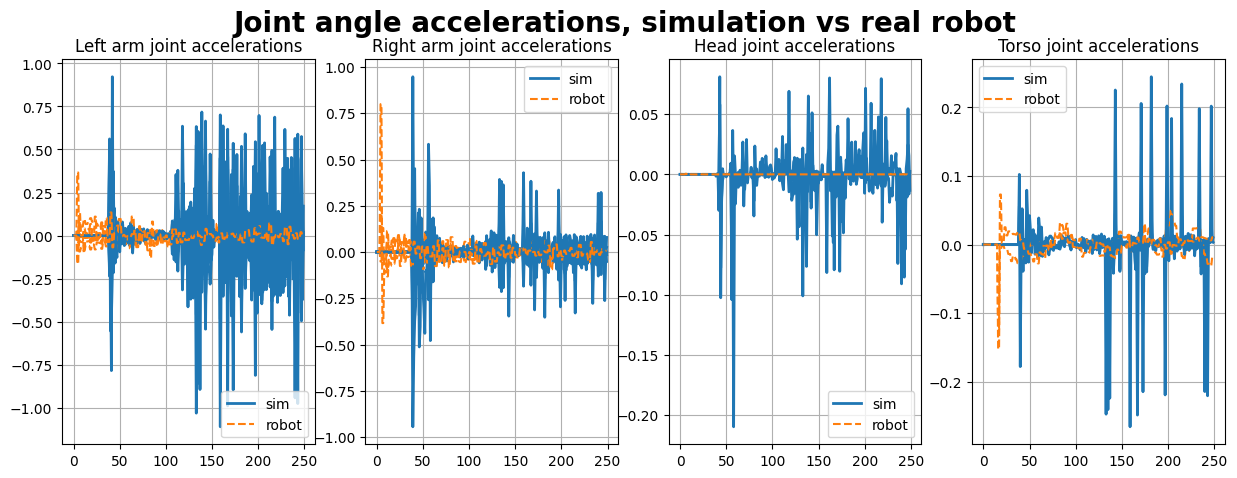

In [40]:
n_dims = 18
acc_sim = cost_vars_sim[:,2*n_dims:3*n_dims]
acc_robot = cost_vars_robot[:,2*n_dims:3*n_dims]

colors = ["tab:blue", "tab:orange", "tab:green", "black", "tab:purple", "tab:gray", "tab:blue"]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,5))
for i in range(7):
    ax1.plot(acc_sim[:,i], linestyle="-", linewidth=2, color=colors[0])
    ax1.plot(acc_robot[:,i], linestyle="--", linewidth=1.5, color=colors[1])
    ax1.set_title("Left arm joint accelerations")
for i in range(7,14):
    ax2.plot(acc_sim[:,i], linestyle="-", linewidth=2, color=colors[0])
    ax2.plot(acc_robot[:,i], linestyle="--", linewidth=1.5, color=colors[1])
    ax2.set_title("Right arm joint accelerations")
for i in range(14,16):
    ax3.plot(acc_sim[:,i], linestyle="-", linewidth=2, color=colors[0])
    ax3.plot(acc_robot[:,i], linestyle="--", linewidth=1.5, color=colors[1])
    ax3.set_title("Head joint accelerations")
for i in range(16,18):
    ax4.plot(acc_sim[:,i], linestyle="-", linewidth=2, color=colors[0])
    ax4.plot(acc_robot[:,i], linestyle="--", linewidth=1.5, color=colors[1])
    ax4.set_title("Torso joint accelerations")    

fig.suptitle("Joint angle accelerations, simulation vs real robot", weight="bold", fontsize=20)
ax1.legend(["sim", "robot"], loc="lower right")
ax2.legend(["sim", "robot"])
ax3.legend(["sim", "robot"])
ax4.legend(["sim", "robot"])

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

# ax3.set_ylim([-0.5, 0.5])

plt.show()